# Text Summarization

In [1]:
import numpy as np
from nltk.tokenize import sent_tokenize
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from operator import itemgetter
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
stop_words = stopwords.words("english")

In [3]:
# sentences = brown.sents('ca01')

sentences = """The PageRank algorithm views the web as a directed graph with the pages being nodes and hyperlinks being connections between those nodes. It can be used to rank the nodes of any kind of graph (including undirected ones) by importance. This description uses graph terminology and only shows how it is done for a directed graph such as the webgraph.
While it is accurate to say that PageRank will tell you the importance of each page, a more accurate definition is that PageRank assigns a probability to each page. Specifically, the PageRank value of a page is the probability, between 0 and 1, that someone surfing by clicking links at random will end up on that page. It also models boredom through a ‘damping factor’: after so many clicks, the simulated surfer will get bored and stop browsing.
Because finding the PageRank probability value for an individual node in a graph will depend on the PageRank value of all the nodes which connect to it, and those nodes might connect cyclically to the node whose ranking we want, PageRank values are usually assigned using a converging iterative method.
The Python procedure takes its argument in a similar format to tsort: the graph argument is an iterable of two-element sequences. It also accepts optional arguments for the damping factor (damping) and the amount of convergence required (epsilon). epsilon is the smallest cumulative change in the PageRank of all nodes which will be accepted as sufficient convergence. """

In [4]:
sentences = sent_tokenize(sentences)

In [5]:
len(sentences)

10

## PageRank Algorithm

In [6]:
def pagerank(M, eps=0.001, d=0.80):
    N = M.shape[1]
    v = np.random.uniform(0, 1, (N, 1))
    v = v / np.linalg.norm(v, 1)
    last_v = np.ones((N, 1), dtype=np.float32) * np.inf
    M_hat = (d * M) + (((1 - d) / N) * np.ones((N, N), dtype=np.float32))
    
    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = np.matmul(M_hat, v)
    return v

### Function to calculate cosine similarity among sentences

In [7]:
def sentence_similarity(sent1, sent2, stop_words=None):
    if stop_words is None:
        stop_words = []
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    
    all_words = list(set(sent1 + sent2))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    
    for w in sent1:
        if w not in stop_words:
            vector1[all_words.index(w)] += 1
    
    for w in sent2:
        if w not in stop_words:
            vector2[all_words.index(w)] += 1
    
    return 1 - cosine_distance(vector1, vector2)

In [8]:
[''.join(sent) for sent in sentences]

['The PageRank algorithm views the web as a directed graph with the pages being nodes and hyperlinks being connections between those nodes.',
 'It can be used to rank the nodes of any kind of graph (including undirected ones) by importance.',
 'This description uses graph terminology and only shows how it is done for a directed graph such as the webgraph.',
 'While it is accurate to say that PageRank will tell you the importance of each page, a more accurate definition is that PageRank assigns a probability to each page.',
 'Specifically, the PageRank value of a page is the probability, between 0 and 1, that someone surfing by clicking links at random will end up on that page.',
 'It also models boredom through a ‘damping factor’: after so many clicks, the simulated surfer will get bored and stop browsing.',
 'Because finding the PageRank probability value for an individual node in a graph will depend on the PageRank value of all the nodes which connect to it, and those nodes might con

### Similarity Adjacency Matrix for PageRank

In [9]:
def build_similarity_matrix(sentences, stop_words=None):
    S = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i == j:
                continue
            else:
                S[i][j] = sentence_similarity(sentences[i], sentences[j], stop_words)
    
    for i in range(len(S)):
        S[i] /= S[i].sum()
    return S

In [10]:
S = build_similarity_matrix(sentences, stop_words)

In [11]:
S

array([[0.        , 0.11023498, 0.11130816, 0.11167268, 0.11145898,
        0.10597873, 0.11439891, 0.11364103, 0.10984641, 0.11146012],
       [0.10923643, 0.        , 0.10857905, 0.1115095 , 0.11299607,
        0.10882081, 0.11452241, 0.11152675, 0.11446541, 0.10834355],
       [0.11066315, 0.10893665, 0.        , 0.11555006, 0.11129961,
        0.11327177, 0.11165814, 0.1127739 , 0.10958736, 0.10625935],
       [0.10826185, 0.10909186, 0.11267372, 0.        , 0.11351447,
        0.11289927, 0.1119161 , 0.11154207, 0.11001917, 0.11008148],
       [0.10865789, 0.11116331, 0.10913494, 0.11414816, 0.        ,
        0.11198367, 0.11424824, 0.10982938, 0.11020138, 0.11063302],
       [0.10536924, 0.10918401, 0.11327675, 0.11578645, 0.11420986,
        0.        , 0.11189047, 0.11314888, 0.10967048, 0.10746385],
       [0.11078296, 0.11191634, 0.10875905, 0.11179313, 0.11348916,
        0.10898056, 0.        , 0.11071771, 0.11138584, 0.11217525],
       [0.11139054, 0.11031742, 0.1111848

In [12]:
sentence_ranks = pagerank(S)

**Sentence Ranked according to their importance**

In [13]:
sentence_ranks

array([[0.0988951 ],
       [0.14573131],
       [0.06021736],
       [0.03058838],
       [0.18859406],
       [0.02688107],
       [0.06916035],
       [0.07405789],
       [0.16705772],
       [0.13881675]])

In [14]:
ranked_sentence_indexes = [item[0] for item in sorted(enumerate(sentence_ranks), key=lambda item: -item[1])]

In [15]:
ranked_sentence_indexes

[4, 8, 1, 9, 0, 7, 6, 2, 3, 5]

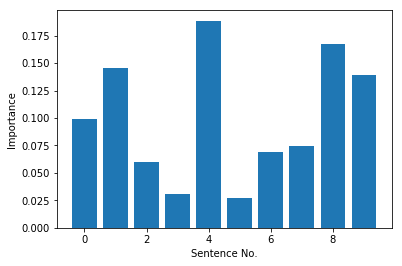

In [16]:
plt.bar([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks.T[0])
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

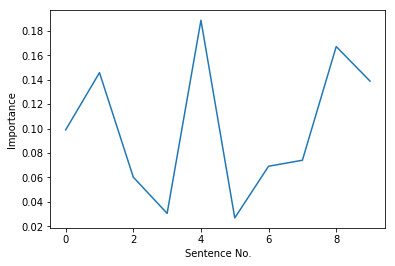

In [17]:
plt.plot([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks)
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

In [18]:
SUMMARY_SIZE = 3

In [19]:
selected_sentences = sorted(ranked_sentence_indexes[:SUMMARY_SIZE])

In [20]:
selected_sentences

[1, 4, 8]

In [21]:
summary = itemgetter(*selected_sentences)(sentences)

**Generated Summary**

In [22]:
for sent in summary:
    print(''.join(sent))

It can be used to rank the nodes of any kind of graph (including undirected ones) by importance.
Specifically, the PageRank value of a page is the probability, between 0 and 1, that someone surfing by clicking links at random will end up on that page.
It also accepts optional arguments for the damping factor (damping) and the amount of convergence required (epsilon).
